# Workshop 05: Spatial Analytics

Content:
    1. GeoPandas (incl. shapely)
    2. H3-Library to discretize an area
    3. Kepler GL to interactively visualize spatial data 


## GeoPandas:
Official Documentation: https://geopandas.org/data_structures.html

    
GeoPandas implements two main data structures, a **GeoSeries** and a **GeoDataFrame**. 
These are subclasses of pandas **Series** and **DataFrame**, respectively.

### GeoSeries

A GeoSeries is essentially a vector where each entry in the vector is a set of shapes corresponding to one observation.

#### Geometry Objects
geopandas has three basic classes of geometric objects (which are actually **shapely** objects):

1. Points / Multi-Points
2. Lines / Multi-Lines
3. polygons / Multi-Polygons

Note that all entries in a GeoSeries need not be of the same geometric type, although certain export operations will fail if this is not the case.



#### Overview of Attributes and Methods 
The GeoSeries class implements nearly all of the attributes and methods of Shapely objects. 
When applied to a GeoSeries, they will apply elementwise to all geometries in the series.

##### Attributes

* area: shape area (units of projection – see projections)
* bounds: tuple of max and min coordinates on each axis for each shape
* total_bounds: tuple of max and min coordinates on each axis for entire GeoSeries
* geom_type: type of geometry.
* is_valid: tests if coordinates make a shape that is reasonable geometric shape.

##### Basic Methods

* distance(): returns Series with minimum distance from each entry to other
* centroid: returns GeoSeries of centroids
* representative_point(): returns GeoSeries of points that are guaranteed to be within each geometry. It does NOT * return centroids.
* to_crs(): change coordinate reference system. See projections
* plot(): plot GeoSeries. See mapping.


##### Relationship Tests

*  geom_almost_equals(): is shape almost the same as other (good when floating point precision issues make shapes slightly different)
* contains(): is shape contained within other
* intersects(): does shape intersect other


### GeoDataFrame

A **GeoDataFrame** is a tabular data structure that contains a GeoSeries.

The most important property of a GeoDataFrame is that it always has **one** GeoSeries column that holds a special status. This GeoSeries is referred to as the GeoDataFrame’s **“geometry”**. When a spatial method is applied to a GeoDataFrame (or a spatial attribute like area is called), this commands will always act on the “geometry” column.



#### Example 

In [1]:
import geopandas 

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# eyeball geopandas data frame
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


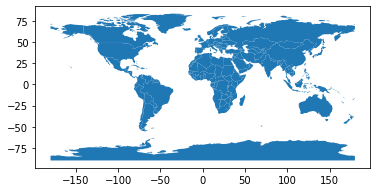

In [3]:
# Plot Spatial Data
world.plot()

In [5]:
# Adjusting the geometry column
world.geometry

'geometry'

In [6]:
# First rename column, second set geometry column -> You have to set the geometry everytime you change the name.
world = world.rename(columns={'geometry': 'borders'}).set_geometry('borders')

world.geometry.name

'borders'

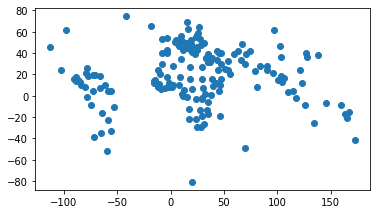

In [10]:
# Compute centroid

world['centroid_column'] = world.centroid

world = world.set_geometry('centroid_column')

world.plot()

# note that the active geometry column has changed

#### Display options 

In [21]:
import geopandas
geopandas.options

Options(
  display_precision: None [default: None]
      The precision (maximum number of decimals) of the coordinates in the
      WKT representation in the Series/DataFrame display. By default (None),
      it tries to infer and use 3 decimals for projected coordinates and 5
      decimals for geographic coordinates.)

In [11]:
# Before changing options 

world['centroid_column'].head()

0    POINT (163.85316 -17.31631)
1      POINT (34.75299 -6.25773)
2     POINT (-12.13783 24.29117)
3     POINT (-98.14238 61.46908)
4    POINT (-112.59944 45.70563)
Name: centroid_column, dtype: geometry

In [12]:
# After changing options
geopandas.options.display_precision = 9

world['centroid_column'].head()

0    POINT (163.853164645 -17.316309426)
1      POINT (34.752989855 -6.257732429)
2     POINT (-12.137831112 24.291172960)
3     POINT (-98.142381372 61.469076145)
4    POINT (-112.599435912 45.705628002)
Name: centroid_column, dtype: geometry

### Reading and Writing Files

Reading Spatial Data

geopandas can read almost any vector-based spatial data format including ESRI shapefile, GeoJSON files and more using the command:

geopandas.read_file()

#### Reading big data files by using geometry filters

In [14]:
# This is our filter
gdf_mask = geopandas.read_file(
    geopandas.datasets.get_path("naturalearth_lowres")
)

# Here we load all cities but apply an filter such that we just get cities that are withing the gdf_mask geometry 
# In this example, we just get cities from Africa
gdf = geopandas.read_file(
    geopandas.datasets.get_path("naturalearth_cities"),
    mask=gdf_mask[gdf_mask.continent=="Africa"],
)

In [15]:
gdf

,name,geometry
0,Moroni,POINT (43.240244099 -11.704157696)
1,Kigali,POINT (30.058585919 -1.951644210)
2,Mbabane,POINT (31.133334512 -26.316650778)
3,Juba,POINT (31.580025593 4.829975198)
4,Djibouti,POINT (43.148001667 11.595014464)
...,...,...
62,Addis Ababa,POINT (38.698058575 9.035256221)
63,Riyadh,POINT (46.770795799 24.642779008)
64,Cape Town,POINT (18.433042299 -33.918065109)
65,Nairobi,POINT (36.814711000 -1.281400883)


#### Writing files

In [49]:
gdf.to_file("african_cities.shp")

# or as GeoJSON

gdf.to_file("african_cities.geojson", driver='GeoJSON')


### Indexing and Selecting Data

GeoPandas inherits the **standard pandas** methods for indexing/selecting data. This includes label based indexing with .loc and integer position based indexing with .iloc, which apply to both GeoSeries and GeoDataFrame objects. For more information on indexing/selecting, see the pandas documentation.

In addition to the standard pandas methods, GeoPandas also provides **coordinate based indexing** with the cx indexer, which slices using a bounding box. Geometries in the GeoSeries or GeoDataFrame that intersect the bounding box will be returned.

Using the world dataset, we can use this functionality to quickly select all countries whose boundaries extend into the southern hemisphere.

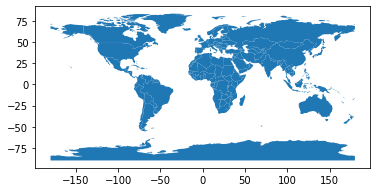

In [17]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


world.plot()

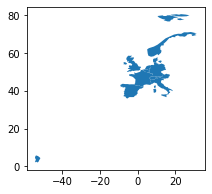

In [18]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

#xmin, xmax, ymin, ymax 
southern_world = world.cx[0:10, 40:60]

southern_world.plot(figsize=(10, 3));

### Making Maps 

In [19]:
# Load Toy data
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))

In [20]:
# Examine world data

world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.000000000 -16.067132664, 1..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.903711197 -0.950000000, 34.072620..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.665589565 27.656425890, -8.665124..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.840000000 49.000000000, -..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.840000000 49.000000000, -..."


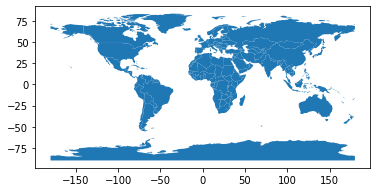

In [21]:
# Plot data
world.plot();

#### Choropleth Maps

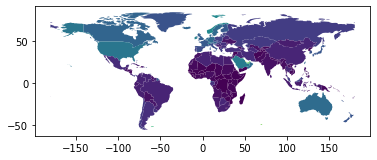

In [68]:
# Plot by GDP per capta
world = world[(world.pop_est>0) & (world.name!="Antarctica")]

world['gdp_per_cap'] = world.gdp_md_est / world.pop_est

world.plot(column='gdp_per_cap');

#### Plotting a legend

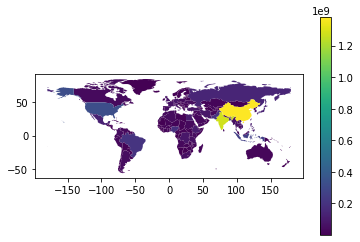

In [71]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

world.plot(column='pop_est', ax=ax, legend=True)

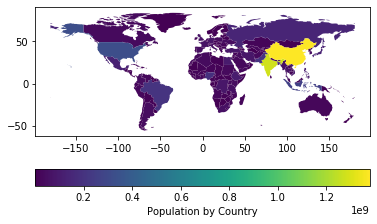

In [74]:
# or horizontally 
fig, ax = plt.subplots(1, 1)
world.plot(column='pop_est',ax=ax,legend=True, legend_kwds={'label': "Population by Country",'orientation': "horizontal"})


#### Changing the default coloring

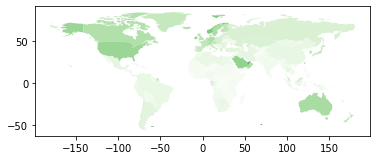

In [77]:
# By adding a colormap
# Here you can find many colormaps: https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
world.plot(column='gdp_per_cap', cmap='Greens');

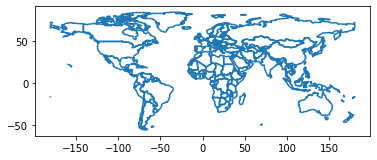

In [78]:
#### Plotting only the boundaries of geometries
world.boundary.plot();

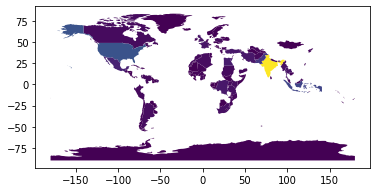

In [23]:
#### Plotting missing data
import numpy as np

world.loc[np.random.choice(world.index, 40), 'pop_est'] = np.nan

# By default these features are ignored
world.plot(column='pop_est');


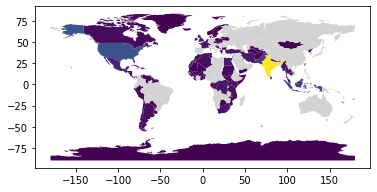

In [24]:
# But we can specfiy a color for missing values
world.plot(column='pop_est', missing_kwds={'color': 'lightgrey'});

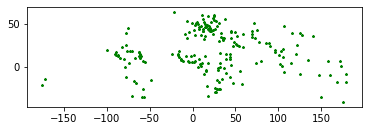

In [25]:
#### Maps with multiple layers (i.e., multiple data sources)

# Second data set 
cities.plot(marker='*', color='green', markersize=5);

cities = cities.to_crs(world.crs)


# Idea: Overlay two plots

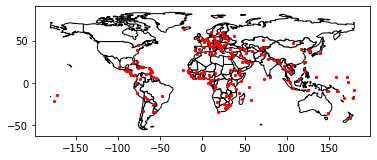

In [93]:
# Plotting two layers
base = world.plot(color='white', edgecolor='black') # This returns an axes object as we have learnt in workshop 2
cities.plot(ax=base, marker='o', color='red', markersize=5);

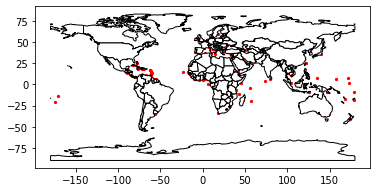

In [28]:
# or, a more "sophisticated" approach: 
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

world.plot(ax=ax, color='white', edgecolor='black')

cities.plot(ax=ax, marker='o', color='red', markersize=5)


plt.show();

#### Control the order of multiple layers in a plot

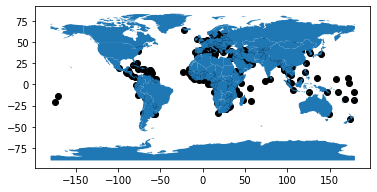

In [29]:
ax = cities.plot(color='k')
world.plot(ax=ax);

# Not very meaningful visualization.

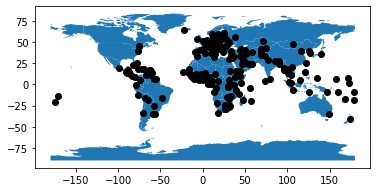

In [30]:
ax = cities.plot(color='k', zorder=2)
world.plot(ax=ax, zorder=1);

# Much better

### Task 1: Plot a heatmap based on the cities data frame 

#### Cities: 
import geopandas
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))

#### Tutorial how to plot heatmaps:
https://nbviewer.jupyter.org/gist/perrygeo/c426355e40037c452434

#### Heat Map

/Users/demircanm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


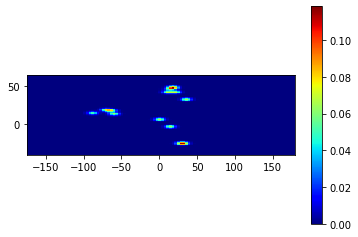

In [31]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    # Imports 
    import geopandas as gpd
    import numpy as np
    from scipy import ndimage

    import matplotlib.pylab as pylab
    import matplotlib.pyplot as plt
    
    # Code
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

heatmap(cities)

### Managing Coordinate Reference System
Coordinate Reference Systems

The Coordinate Reference System (CRS) is important because the geometric shapes in a GeoSeries or GeoDataFrame object are simply a collection of coordinates in an arbitrary space. A CRS tells Python how those coordinates relate to places on the Earth.

You can find the codes for most commonly used projections from www.spatialreference.org.

The same CRS can often be referred to in many ways. For example, one of the most commonly used CRS is the WGS84 latitude-longitude projection. This can be referred to using the authority code "EPSG:4326".

#### Setting a CRS manually

In [32]:
# But most of the time we don't need to this because this information is available in the input data.
cities.crs = "EPSG:4326" 

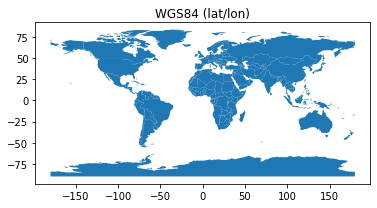

In [33]:
#### Transforming to different projection

world.crs # EPSG:4326 <-> WGS 84 most commonly used system

ax = world.plot()

ax.set_title("WGS84 (lat/lon)");

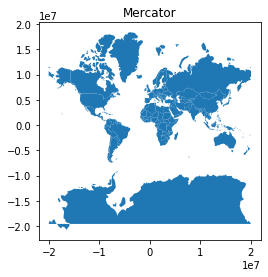

In [35]:
# Projecting it to mercator projection
world_merc = world.to_crs("EPSG:3395") 
ax = world_merc.plot()

ax.set_title("Mercator");

### Geometric Manipulations 

**GeoSeries.buffer(distance, resolution=16)**
Returns a GeoSeries of geometries representing all points within a given distance of each geometric object.

**GeoSeries.boundary**
Returns a GeoSeries of lower dimensional objects representing each geometries’s set-theoretic boundary.

**GeoSeries.centroid**
Returns a GeoSeries of points for each geometric centroid.

**GeoSeries.convex_hull**
Returns a GeoSeries of geometries representing the smallest convex Polygon containing all the points in each object unless the number of points in the object is less than three. For two points, the convex hull collapses to a LineString; for 1, a Point.

**GeoSeries.envelope**
Returns a GeoSeries of geometries representing the point or smallest rectangular polygon (with sides parallel to the coordinate axes) that contains each object.

**GeoSeries.simplify(tolerance, preserve_topology=True)**
Returns a GeoSeries containing a simplified representation of each object.

**GeoSeries.unary_union**
Return a geometry containing the union of all geometries in the GeoSeries.


### Affine Transformation

**GeoSeries.affine_transform(self, matrix)**
Transform the geometries of the GeoSeries using an affine transformation matrix

**GeoSeries.rotate(self, angle, origin='center', use_radians=False)**
Rotate the coordinates of the GeoSeries.

**GeoSeries.scale(self, xfact=1.0, yfact=1.0, zfact=1.0, origin='center')**
Scale the geometries of the GeoSeries along each (x, y, z) dimensio.

**GeoSeries.skew(self, angle, origin='center', use_radians=False)**
Shear/Skew the geometries of the GeoSeries by angles along x and y dimensions.

**GeoSeries.translate(self, xoff=0.0, yoff=0.0, zoff=0.0)**
Shift the coordinates of the GeoSeries.




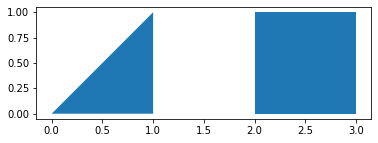

In [36]:
# Create Toy Data

import geopandas
from geopandas import GeoSeries
from shapely.geometry import Polygon
p1 = Polygon([(0, 0), (1, 0), (1, 1)])
p2 = Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])
g = GeoSeries([p1, p2])
g.plot()

In [38]:
# Area of objects
g.area

0    0.5
1    1.0
dtype: float64

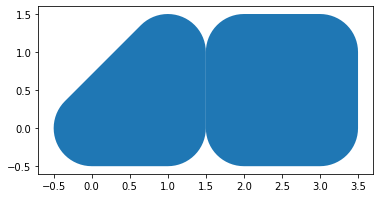

In [122]:
g.buffer(0.5).plot()

In [39]:
# Example 2: NY districts
nybb_path = geopandas.datasets.get_path('nybb')
boros = geopandas.read_file(nybb_path)
boros.set_index('BoroCode', inplace=True)
boros.sort_index(inplace=True)
boros


,BoroName,Shape_Leng,Shape_Area,geometry
BoroCode,,,,
1,Manhattan,359299.096471,6.364715e+08,MULTIPOLYGON (((981219.055786133 188655.315795...
2,Bronx,464392.991824,1.186925e+09,MULTIPOLYGON (((1012821.805786133 229228.26458...
3,Brooklyn,741080.523166,1.937479e+09,MULTIPOLYGON (((1021176.479003906 151374.79699...
4,Queens,896344.047763,3.045213e+09,MULTIPOLYGON (((1029606.076599121 156073.81420...
5,Staten Island,330470.010332,1.623820e+09,MULTIPOLYGON (((970217.022399902 145643.332214...


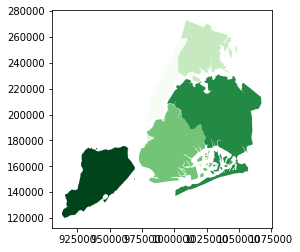

In [126]:
# Plot NY districts
boros.plot(cmap="Greens")

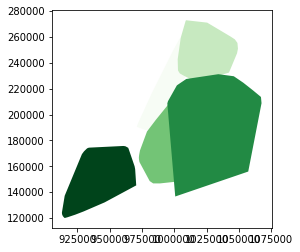

In [128]:
# Compute the convex hull
boros['geometry'].convex_hull.plot(cmap="Greens")

In [40]:
#### A more complex operation with random "mobility data":

import numpy as np
from shapely.geometry import Point
xmin, xmax, ymin, ymax = 900000, 1080000, 120000, 280000
xc = (xmax - xmin) * np.random.random(2000) + xmin
yc = (ymax - ymin) * np.random.random(2000) + ymin
pts = GeoSeries([Point(x, y) for x, y in zip(xc, yc)])

In [41]:
# Compute a buffer around each vehicle
circles = pts.buffer(2000)

In [42]:
# Compute unary union
mp = circles.unary_union

In [43]:
type(mp)

shapely.geometry.multipolygon.MultiPolygon

In [44]:
# This is one single shapley! object. 
mp

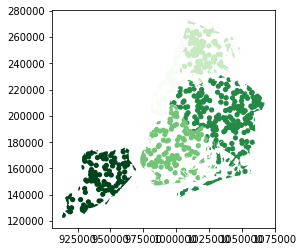

In [45]:
# Computing the intersection 
holes = boros['geometry'].intersection(mp) # N - 1 

holes.plot(cmap="Greens")

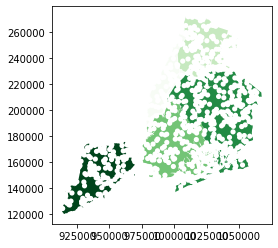

In [46]:
# Or the difference
boros_with_holes = boros['geometry'].difference(mp)

boros_with_holes.plot(cmap="Greens")

### Set-Operations with Overlay

When working with multiple spatial datasets – especially multiple polygon or line datasets – users often wish to create new shapes based on places where those datasets overlap (or don’t overlap). These manipulations are often referred using the language of sets – intersections, unions, and differences. These types of operations are made available in the geopandas library through the overlay function.

In [50]:
from shapely.geometry import Polygon

polys1 = geopandas.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)]),
                              Polygon([(2,2), (4,2), (4,4), (2,4)])])


polys2 = geopandas.GeoSeries([Polygon([(1,1), (3,1), (3,3), (1,3)]),
                              Polygon([(3,3), (5,3), (5,5), (3,5)])])


df1 = geopandas.GeoDataFrame({'geometry': polys1, 'df1':[1,2]})

df2 = geopandas.GeoDataFrame({'geometry': polys2, 'df2':[1,2]})

df1

,geometry,df1
0,"POLYGON ((0.000000000 0.000000000, 2.000000000...",1
1,"POLYGON ((2.000000000 2.000000000, 4.000000000...",2


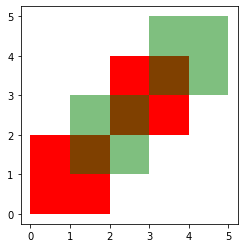

In [51]:
# Plot to y data
ax = df1.plot(color='red');

df2.plot(ax=ax, color='green', alpha=0.5);

In [52]:
# Union Operator
res_union = geopandas.overlay(df1, df2, how='union')

In [56]:
res_union.head(10)

,df1,df2,geometry
0,1.0,1.0,"POLYGON ((1.000000000 2.000000000, 2.000000000..."
1,2.0,1.0,"POLYGON ((2.000000000 2.000000000, 2.000000000..."
2,2.0,2.0,"POLYGON ((3.000000000 4.000000000, 4.000000000..."
3,1.0,NaN,"POLYGON ((0.000000000 0.000000000, 0.000000000..."
4,2.0,NaN,"MULTIPOLYGON (((2.000000000 3.000000000, 2.000..."
5,NaN,1.0,"MULTIPOLYGON (((1.000000000 2.000000000, 1.000..."
6,NaN,2.0,"POLYGON ((3.000000000 4.000000000, 3.000000000..."


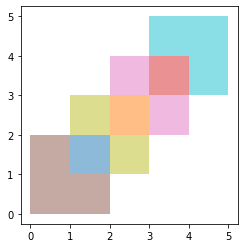

In [55]:
# Vis. union
ax = res_union.plot(alpha=0.5, cmap='tab10')

# Color the edges
#df1.plot(ax=ax, facecolor='none', edgecolor='k');
#df1.plot(ax=ax, facecolor='none', edgecolor='k');

#### Task two:
from shapely.geometry import Polygon

polys1 = geopandas.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)]),
                              Polygon([(2,2), (4,2), (4,4), (2,4)])])


polys2 = geopandas.GeoSeries([Polygon([(1,1), (3,1), (3,3), (1,3)]),
                              Polygon([(3,3), (5,3), (5,5), (3,5)])])


df1 = geopandas.GeoDataFrame({'geometry': polys1, 'df1':[1,2]})

df2 = geopandas.GeoDataFrame({'geometry': polys2, 'df2':[1,2]})


1. Compute Intersection, Sym. Difference and Difference
2. Plot results

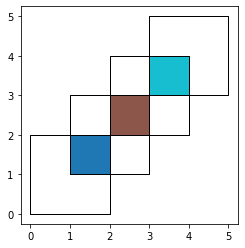

In [57]:
# Intersection
res_intersection = geopandas.overlay(df1, df2, how='intersection')

ax = res_intersection.plot(cmap='tab10')

df1.plot(ax=ax, facecolor='none', edgecolor='k');

df2.plot(ax=ax, facecolor='none', edgecolor='k');

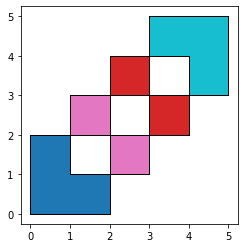

In [168]:
# Sym. Difference
res_symdiff = geopandas.overlay(df1, df2, how='symmetric_difference')

ax = res_symdiff.plot(cmap='tab10')

df1.plot(ax=ax, facecolor='none', edgecolor='k');

df2.plot(ax=ax, facecolor='none', edgecolor='k');

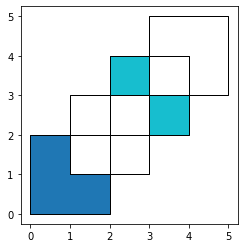

In [167]:
# Difference
res_difference = geopandas.overlay(df1, df2, how='difference')

ax = res_difference.plot(cmap='tab10')

df1.plot(ax=ax, facecolor='none', edgecolor='k');

df2.plot(ax=ax, facecolor='none', edgecolor='k');

### Aggregration with dissolve (SQL Equivalent: GroupBy)

Aggregation with dissolve

Spatial data are often more granular than we need. For example, we might have data on sub-national units, but we’re actually interested in studying patterns at the level of countries.

In a non-spatial setting, when all we need are summary statistics of the data, we aggregate our data using the **groupby** function. But for spatial data, we sometimes also need to aggregate geometric features. In the geopandas library, we can aggregate geometric features using the dissolve function.

dissolve can be thought of as doing three things: (a) it dissolves all the geometries within a given group together into a single geometric feature (using the unary_union method), and (b) it aggregates all the rows of data in a group using groupby.aggregate(), and (c) it combines those two results.



In [58]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

world = world[['continent', 'geometry', 'name']]

world.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 3 columns):
continent    177 non-null object
geometry     177 non-null geometry
name         177 non-null object
dtypes: geometry(1), object(2)
memory usage: 4.3+ KB


In [59]:
world.head()

,continent,geometry,name
0,Oceania,"MULTIPOLYGON (((180.000000000 -16.067132664, 1...",Fiji
1,Africa,"POLYGON ((33.903711197 -0.950000000, 34.072620...",Tanzania
2,Africa,"POLYGON ((-8.665589565 27.656425890, -8.665124...",W. Sahara
3,North America,"MULTIPOLYGON (((-122.840000000 49.000000000, -...",Canada
4,North America,"MULTIPOLYGON (((-122.840000000 49.000000000, -...",United States of America


In [60]:
# "GroupBy" Continent and merge geometries
continents = world.dissolve(by='continent')

In [61]:
# GroupedBy/Dissolved Geometries
continents.head()

,geometry,name
continent,,
Africa,"MULTIPOLYGON (((32.830120477 -26.742191664, 32...",Tanzania
Antarctica,"MULTIPOLYGON (((-163.712895678 -78.595667413, ...",Antarctica
Asia,"MULTIPOLYGON (((120.295014276 -10.258649998, 1...",Kazakhstan
Europe,"MULTIPOLYGON (((-51.657797411 4.156232408, -52...",Russia
North America,"MULTIPOLYGON (((-61.680000000 10.760000000, -6...",Canada


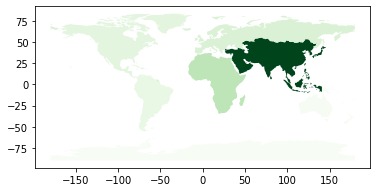

In [62]:
# Population - Continent Level
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

world = world[['continent', 'geometry', 'pop_est']]

continents = world.dissolve(by='continent', aggfunc='sum')

continents.plot(column = 'pop_est', cmap='Greens');

# Equivalent SQL:

# SELECT union(geometry), sum(population) from table naturalearth_lowres group by continent;

### Merging Data (SQL Equivalent: Join)

Both spatial and attribute joins are supported. Attribute joins are done in the same way as in with regular pandas.

Spatial Join are used to join "spatially" related data.

In [63]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))

# For attribute join
country_shapes = world[['geometry', 'iso_a3']]

country_names = world[['name', 'iso_a3']]

# For spatial join
countries = world[['geometry', 'name']]

countries = countries.rename(columns={'name':'country'})

In [64]:
# Eyeball countries 
countries.head()

,geometry,country
0,"MULTIPOLYGON (((180.000000000 -16.067132664, 1...",Fiji
1,"POLYGON ((33.903711197 -0.950000000, 34.072620...",Tanzania
2,"POLYGON ((-8.665589565 27.656425890, -8.665124...",W. Sahara
3,"MULTIPOLYGON (((-122.840000000 49.000000000, -...",Canada
4,"MULTIPOLYGON (((-122.840000000 49.000000000, -...",United States of America


In [65]:
# Eyeball cities
cities.head()

,name,geometry
0,Vatican City,POINT (12.453386545 41.903282180)
1,San Marino,POINT (12.441770158 43.936095835)
2,Vaduz,POINT (9.516669473 47.133723774)
3,Luxembourg,POINT (6.130002806 49.611660379)
4,Palikir,POINT (158.149974324 6.916643696)


In [67]:
# Execute spatial join (merge both data frames bases on spatial relationship)
# How: Inner, Left, Right 
# Op: intersects (intersection is not empty), within (is within the other object's interior), contains (contains the other objects)
cities_with_country = geopandas.sjoin(cities, countries, how="inner", op='intersects')

In [68]:
cities_with_country.head()

,name,geometry,index_right,country
0,Vatican City,POINT (12.453386545 41.903282180),141,Italy
1,San Marino,POINT (12.441770158 43.936095835),141,Italy
192,Rome,POINT (12.481312563 41.897901485),141,Italy
2,Vaduz,POINT (9.516669473 47.133723774),114,Austria
184,Vienna,POINT (16.364693097 48.201961137),114,Austria


#### Missing and Empty Geometries: 

1. Empty geometries = real geometry objects but with no coordinates (e.g., intersection of polygons without any intersecting point)
2. Missing geometries = None values 

## H3 - Hierarchical Discretization with Hexagons

# Source:
1. https://www.google.com/search?client=safari&rls=en&q=source+h3&ie=UTF-8&oe=UTF-8
2. https://eng.uber.com/h3/ 
3. Documentation: https://h3geo.org/#/

<img src="resources/img1.png">

<img src="resources/img2.png">

<img src="resources/img3.png">

In [69]:
import json
city_bounding_box = geopandas.read_file('./resources/berlin_bounding_box.geojson')
city_bounding_box_json_string = city_bounding_box.to_json()
city_bounding_box_json = json.loads(city_bounding_box_json_string)
city_bounding_box_poly = city_bounding_box_json["features"][0]

In [70]:
# Valid GeoJSON object
city_bounding_box_poly

{'id': '0',
 'type': 'Feature',
 'properties': {},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[13.0133056640625, 52.35715118125809],
    [13.750762939453125, 52.35715118125809],
    [13.750762939453125, 52.65222859561964],
    [13.0133056640625, 52.65222859561964],
    [13.0133056640625, 52.35715118125809]]]}}

In [71]:
from h3 import h3 
from shapely.geometry import shape

# Computing hexagons for a given polygon
H3_HEXAGON_RESOLUTION = 7
polygon_obj = city_bounding_box_poly["geometry"] # your geo json object
hexagons = h3.polyfill(geo_json = polygon_obj, res = H3_HEXAGON_RESOLUTION, geo_json_conformant = True)

In [72]:
# Returns only the index of each hexagon, not the geometries
hexagons

{'871f18809ffffff',
 '871f1880bffffff',
 '871f1880dffffff',
 '871f18829ffffff',
 '871f18840ffffff',
 '871f18841ffffff',
 '871f18842ffffff',
 '871f18843ffffff',
 '871f18844ffffff',
 '871f18845ffffff',
 '871f18846ffffff',
 '871f18848ffffff',
 '871f18849ffffff',
 '871f1884affffff',
 '871f1884bffffff',
 '871f1884cffffff',
 '871f1884dffffff',
 '871f1884effffff',
 '871f18850ffffff',
 '871f18851ffffff',
 '871f18854ffffff',
 '871f18855ffffff',
 '871f18856ffffff',
 '871f18859ffffff',
 '871f1885cffffff',
 '871f1885dffffff',
 '871f18860ffffff',
 '871f18861ffffff',
 '871f18862ffffff',
 '871f18863ffffff',
 '871f18864ffffff',
 '871f18865ffffff',
 '871f18866ffffff',
 '871f18868ffffff',
 '871f18869ffffff',
 '871f1886affffff',
 '871f1886bffffff',
 '871f1886cffffff',
 '871f1886dffffff',
 '871f1886effffff',
 '871f18870ffffff',
 '871f18871ffffff',
 '871f18872ffffff',
 '871f18873ffffff',
 '871f18874ffffff',
 '871f18875ffffff',
 '871f18876ffffff',
 '871f18940ffffff',
 '871f18941ffffff',
 '871f18942ffffff',


In [73]:
# Convert H3 Indexes to Geometry Objects

# Create geo data frame
df = geopandas.GeoDataFrame(list(hexagons), columns=['h3_hex_id'], crs="EPSG:4326")

df['geometry'] = df[(df['h3_hex_id'].notna())].apply(lambda row: shape({"type": "Polygon",
                                           "coordinates": [h3.h3_to_geo_boundary(h3_address=row["h3_hex_id"], geo_json=True)],
                                           "properties": ""
                                           }), axis=1)

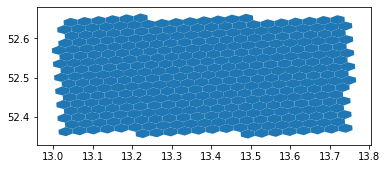

In [74]:
df.plot()

In [ ]:
# Get the hexagon for a data point
# Assume we have a dataframe with a column for latitude and longitude representing "point data".
trips["h3_hex_id"] = trips.apply(lambda row: h3.geo_to_h3(row["latitude"], row["longitude"], H3_HEXAGON_RESOLUTION) if (row['latitude_start'] and row['longitude_start']) else 0, axis=1)




## Interactive Visualization with Kepler.GL

Source: https://kepler.gl